# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
# Import necessary libraries
import numpy as np
import os
from skimage.io import imread
from skimage.transform import resize as imresize
import matplotlib.pyplot as plt
import datetime
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [2]:
# Import tensorflow and keras
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [153]:
from tensorflow.python.client import device_lib

In [154]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7218533588770449606
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2260153140
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16115823103613201846
 physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [3]:
# Read file
train_doc = np.random.permutation(open('Project_data//train.csv').readlines())
val_doc = np.random.permutation(open('Project_data//val.csv').readlines())
batch_size = 12 #experiment with the batch size

- The batch size is optimised according to the GPU supported memory. I tried with 16 batch size and it failed because the GPU was not able to process that volume of data in one batch. So the optimum batch size that was supported by my system was 12. I have trained the models with batch size 12

#### Image preprocessing:

In [5]:
# Defining indexes of images to be used for training
def img_indx(a, b, c):
    img_idx = [i for i in range(a,b,c)]  #recreate a list of image numbers you want to use for a particular video
    return img_idx
    print('Number of images per video used to train the model:', len(img_idx))

In [6]:
def image_resize(image, y, z):
    return imresize(image,output_shape=(y,z))

In [7]:
def image_normalise(image):
    return image/255

In [8]:
def image_preprocessed(image, y, z):
    return image_normalise(image_resize(image, y, z))

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #img_idx = #recreate a list of image numbers you want to use for a particular video
    x = len(img_idx)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = round(len(folder_list)//batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = image_preprocessed(image[:, :, 0], y, z) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_preprocessed(image[:, :, 1], y, z) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_preprocessed(image[:, :, 2], y, z) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if len(folder_list)%batch_size != 0:
            batch_size_res = len(folder_list)%batch_size
            batch += 1
            batch_data = np.zeros((batch_size_res,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size_res,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size_res): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size_res)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size_res)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = image_preprocessed(image[:, :, 0], y, z) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_preprocessed(image[:, :, 1], y, z) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_preprocessed(image[:, :, 2], y, z) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size_res)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data//train'
val_path = 'Project_data//val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [13]:
# Importing Keras libraries
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, GlobalAveragePooling2D
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#### Pointers:
- We are using Resize and Normalise techniques to process our images before feeding them to the model
- We can see that the images are cropped only for the gesture part for each of the gestures in the dataset. This is why I am not cropping the data any further as it might delete necessary information from the data that can be useful for the training.

### Model - I

### - Convolution 3D model

We are bulding the first Convolution 3D model with the following specifications:
- The model has 10 layers with 4 convolution 3D layers and 3 MaxPooling layers 
- The filtersize we are going to use is 3, 3, 3
- We are going to take odd indexed images from each video file for our training
- We are using an image size of 160X160 for training this model
- The learning rate is set to 0.0005

In [14]:
# Parameters
dense = 64
classes = 5
filtersize = (3, 3, 3)
a,b,c = 1, 29, 2
img_idx = img_indx(a, b, c)
x = len(img_idx)
y,z = 160, 160
lr1 = 0.0005

In [15]:
# Input
input_shape=(x, y, z, 3)

# Model
model = Sequential()

model.add(Conv3D(16, filtersize, padding='same', input_shape=input_shape, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2 , 2, 2)))

model.add(Conv3D(32, filtersize, padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

model.add(Conv3D(64, filtersize, padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

model.add(Conv3D(128, filtersize, padding='same', activation='relu'))

model.add(Flatten())
model.add(Dense(dense, activation='relu'))

model.add(Dense(classes, activation='softmax'))

In [16]:
optimiser = tf.keras.optimizers.Adam(learning_rate=lr1, clipnorm=1.) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 14, 160, 160, 16)  1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 80, 80, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 80, 80, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 3, 40, 40, 32)    0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 3, 40, 40, 64)     55360     
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 1, 20, 20, 64)    0

In [17]:
model_name = 'Gesture_recognition' + '' + str(curr_dt_time).replace(' ','').replace(':','') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10, verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0, min_lr = 0)
callbacks_list = [checkpoint, LR]

In [18]:
# Invoking generator function to call from models
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [19]:
stat = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data//train ; batch size = 12
Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 1.5455 - categorical_accuracy: 0.2579Source path =  Project_data//val ; batch size = 12

Epoch 1: saving model to Gesture_recognition2022-03-30042043.466279\model-00001-1.54549-0.25792-1.28595-0.39000.h5
56/56 [==============================] - 87s 1s/step - loss: 1.5455 - categorical_accuracy: 0.2579 - val_loss: 1.2859 - val_categorical_accuracy: 0.3900 - lr: 5.0000e-04
Epoch 2/30
56/56 [==============================] - ETA: 0s - loss: 1.0065 - categorical_accuracy: 0.5837
Epoch 2: saving model to Gesture_recognition2022-03-30042043.466279\model-00002-1.00648-0.58371-0.71769-0.67000.h5
56/56 [==============================] - 72s 1s/step - loss: 1.0065 - categorical_accuracy: 0.5837 - val_loss: 0.7177 - val_categorical_accuracy: 0.6700 - lr: 5.0000e-04
Epoch 3/30
56/56 [==============================] - ETA: 0s - loss: 0.6267 - categorical_accuracy: 0.7738
Epoch 3:

56/56 [==============================] - 72s 1s/step - loss: 2.4686e-05 - categorical_accuracy: 1.0000 - val_loss: 1.5588 - val_categorical_accuracy: 0.8000 - lr: 5.0000e-05
Epoch 22/30
56/56 [==============================] - ETA: 0s - loss: 2.4050e-05 - categorical_accuracy: 1.0000
Epoch 22: saving model to Gesture_recognition2022-03-30042043.466279\model-00022-0.00002-1.00000-1.29459-0.83000.h5
56/56 [==============================] - 71s 1s/step - loss: 2.4050e-05 - categorical_accuracy: 1.0000 - val_loss: 1.2946 - val_categorical_accuracy: 0.8300 - lr: 5.0000e-05
Epoch 23/30
56/56 [==============================] - ETA: 0s - loss: 2.2928e-05 - categorical_accuracy: 1.0000
Epoch 23: saving model to Gesture_recognition2022-03-30042043.466279\model-00023-0.00002-1.00000-1.42343-0.84000.h5
56/56 [==============================] - 71s 1s/step - loss: 2.2928e-05 - categorical_accuracy: 1.0000 - val_loss: 1.4234 - val_categorical_accuracy: 0.8400 - lr: 5.0000e-05
Epoch 24/30
56/56 [=====

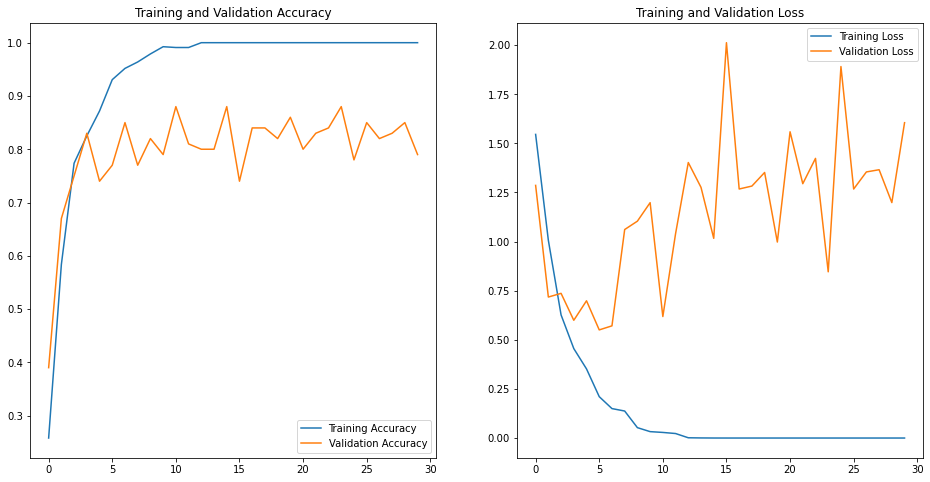

In [20]:
# Visualizing Model performance in a graph
acc = stat.history['categorical_accuracy']
val_acc = stat.history['val_categorical_accuracy']

loss = stat.history['loss']
val_loss = stat.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:

- We can see that the loss for the validation data keeps increasing after a few epochs which suggests that the model is overfitting the training data
- The best performance of this model is at training accuracy of **99%** and validation accuracy of **88%**  
- We used image size of 160X160 for the above model. Let's check the model performance for a smaller image size

### Model - II

### - Convolution layers: 3D model - image resizing

We are bulding the second Convolution 3D model with the following specifications:
- The model has 10 layers with 4 convolution 3D layers and 3 MaxPooling layers 
- The filtersize we are going to use is 3, 3, 3
- We are going to take odd indexed images from each video file for our training
- We are using an image size of 100X100 for training this model
- The learning rate is set to 0.0005

In [21]:
# Parameters
dense = 64
classes = 5
filtersize = (3, 3, 3)
a,b,c = 1, 29, 2
img_idx = img_indx(a, b, c)
x = len(img_idx)
y,z = 100, 100
lr1 = 0.0005

In [22]:
# Input
input_shape=(x, y, z, 3)

# model2
model2 = Sequential()

model2.add(Conv3D(16, filtersize, padding='same', input_shape=input_shape, activation='relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2 , 2, 2)))

model2.add(Conv3D(32, filtersize, padding='same', activation='relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

model2.add(Conv3D(64, filtersize, padding='same', activation='relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

model2.add(Conv3D(128, filtersize, padding='same', activation='relu'))

model2.add(Flatten())
model2.add(Dense(64, activation='relu'))

model2.add(Dense(classes, activation='softmax'))

In [23]:
optimiser = tf.keras.optimizers.Adam(learning_rate=lr1, clipnorm=1.) #write your optimizer
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 14, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 50, 50, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 7, 50, 50, 32)     13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 3, 25, 25, 32)    0         
 3D)                                                             
                                                                 
 conv3d_6 (Conv3D)           (None, 3, 25, 25, 64)     55360     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 1, 12, 12, 64)   

In [24]:
# Invoking generator function to call from models
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [25]:
model_name = 'Gesture_recognition' + '' + str(curr_dt_time).replace(' ','').replace(':','') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10, verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0, min_lr = 0)
callbacks_list = [checkpoint, LR]

In [26]:
stat2 = model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data//train ; batch size = 12
Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 1.5981 - categorical_accuracy: 0.2036Source path =  Project_data//val ; batch size = 12

Epoch 1: saving model to Gesture_recognition2022-03-30042043.466279\model-00001-1.59806-0.20362-1.48467-0.42000.h5
56/56 [==============================] - 59s 1s/step - loss: 1.5981 - categorical_accuracy: 0.2036 - val_loss: 1.4847 - val_categorical_accuracy: 0.4200 - lr: 5.0000e-04
Epoch 2/30
56/56 [==============================] - ETA: 0s - loss: 1.2498 - categorical_accuracy: 0.4932
Epoch 2: saving model to Gesture_recognition2022-03-30042043.466279\model-00002-1.24978-0.49321-1.05505-0.60000.h5
56/56 [==============================] - 60s 1s/step - loss: 1.2498 - categorical_accuracy: 0.4932 - val_loss: 1.0550 - val_categorical_accuracy: 0.6000 - lr: 5.0000e-04
Epoch 3/30
56/56 [==============================] - ETA: 0s - loss: 0.8969 - categorical_accuracy: 0.6501
Epoch 3:

Epoch 22/30
56/56 [==============================] - ETA: 0s - loss: 1.2979e-04 - categorical_accuracy: 1.0000
Epoch 22: saving model to Gesture_recognition2022-03-30042043.466279\model-00022-0.00013-1.00000-0.91218-0.85000.h5
56/56 [==============================] - 59s 1s/step - loss: 1.2979e-04 - categorical_accuracy: 1.0000 - val_loss: 0.9122 - val_categorical_accuracy: 0.8500 - lr: 5.0000e-05
Epoch 23/30
56/56 [==============================] - ETA: 0s - loss: 1.2172e-04 - categorical_accuracy: 1.0000
Epoch 23: saving model to Gesture_recognition2022-03-30042043.466279\model-00023-0.00012-1.00000-0.67123-0.86000.h5
56/56 [==============================] - 59s 1s/step - loss: 1.2172e-04 - categorical_accuracy: 1.0000 - val_loss: 0.6712 - val_categorical_accuracy: 0.8600 - lr: 5.0000e-05
Epoch 24/30
56/56 [==============================] - ETA: 0s - loss: 1.1455e-04 - categorical_accuracy: 1.0000
Epoch 24: saving model to Gesture_recognition2022-03-30042043.466279\model-00024-0.0001

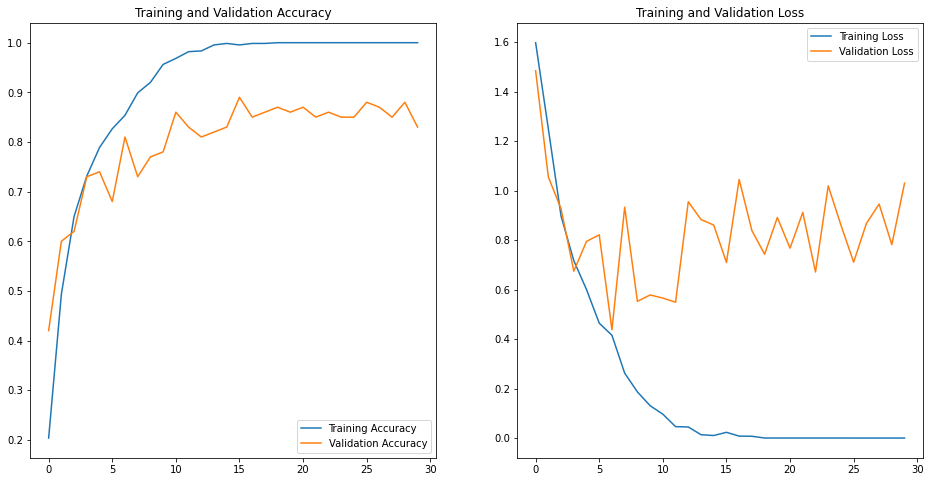

In [27]:
# Visualizing Model performance in a graph
acc = stat2.history['categorical_accuracy']
val_acc = stat2.history['val_categorical_accuracy']

loss = stat2.history['loss']
val_loss = stat2.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:

- We can see that the loss for the validation data keeps increasing after a few epochs which suggests that the model is overfitting the training data
- This model performance is better than the previous one since the loss is less with lower image sizes. We are going to use this image size for the rest of the models
- The best performance of this model is at training accuracy of **99.5%** and validation accuracy of **89.0%**  
- We used image size of 100X100 for the above model. Let's check the model performance with Batch normalisation

### Model - III

### - Convolution 3D model with Batch Normalisation

We are bulding the third Convolution 3D model with the following specifications:
- The model has 15 layers with 4 convolution 3D layers and 3 MaxPooling layers 
- The filtersize we are going to use is 3, 3, 3
- We are going to take odd indexed images from each video file for our training
- We are using an image size of 100X100 for training this model
- The learning rate is set to 0.0005
- We are adding Batch normalization in this model to check for performance improvements

In [28]:
# Parameters
dense = 64
classes = 5
filtersize = (3, 3, 3)
a,b,c = 1, 29, 2
img_idx = img_indx(a, b, c)
x = len(img_idx)
y,z = 100, 100
lr1 = 0.0005

In [29]:
# Input
input_shape=(x, y, z, 3)

# Model
model3 = Sequential()

model3.add(Conv3D(16, filtersize, padding='same', input_shape=input_shape, activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2 , 2, 2)))

model3.add(Conv3D(32, filtersize, padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

model3.add(Conv3D(64, filtersize, padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

model3.add(Conv3D(128, filtersize, padding='same', activation='relu'))
model3.add(BatchNormalization())

model3.add(Flatten())
model3.add(Dense(dense, activation='relu'))
model3.add(BatchNormalization())

model3.add(Dense(classes, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [30]:
optimiser = tf.keras.optimizers.Adam(learning_rate=lr1, clipnorm=1.) #write your optimizer
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 14, 100, 100, 16)  1312      
                                                                 
 batch_normalization (BatchN  (None, 14, 100, 100, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 7, 50, 50, 16)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 7, 50, 50, 32)     13856     
                                                                 
 batch_normalization_1 (Batc  (None, 7, 50, 50, 32)    128       
 hNormalization)                                                 
                                                      

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [31]:
# Invoking generator function to call from models
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [32]:
model_name = 'Gesture_recognition' + '' + str(curr_dt_time).replace(' ','').replace(':','') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10, verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0, min_lr = 0)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [33]:
stat3 = model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data//train ; batch size = 12
Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 1.2553 - categorical_accuracy: 0.5385Source path =  Project_data//val ; batch size = 12

Epoch 1: saving model to Gesture_recognition2022-03-30042043.466279\model-00001-1.25533-0.53846-2.55162-0.21000.h5
56/56 [==============================] - 60s 1s/step - loss: 1.2553 - categorical_accuracy: 0.5385 - val_loss: 2.5516 - val_categorical_accuracy: 0.2100 - lr: 5.0000e-04
Epoch 2/30
56/56 [==============================] - ETA: 0s - loss: 0.5024 - categorical_accuracy: 0.8069
Epoch 2: saving model to Gesture_recognition2022-03-30042043.466279\model-00002-0.50235-0.80694-5.37440-0.23000.h5
56/56 [==============================] - 59s 1s/step - loss: 0.5024 - categorical_accuracy: 0.8069 - val_loss: 5.3744 - val_categorical_accuracy: 0.2300 - lr: 5.0000e-04
Epoch 3/30
56/56 [==============================] - ETA: 0s - loss: 0.3100 - categorical_accuracy: 0.8808
Epoch 3:

Epoch 22/30
56/56 [==============================] - ETA: 0s - loss: 0.0110 - categorical_accuracy: 1.0000
Epoch 22: saving model to Gesture_recognition2022-03-30042043.466279\model-00022-0.01097-1.00000-0.74515-0.81000.h5
56/56 [==============================] - 60s 1s/step - loss: 0.0110 - categorical_accuracy: 1.0000 - val_loss: 0.7452 - val_categorical_accuracy: 0.8100 - lr: 5.0000e-04
Epoch 23/30
56/56 [==============================] - ETA: 0s - loss: 0.0196 - categorical_accuracy: 0.9955
Epoch 23: saving model to Gesture_recognition2022-03-30042043.466279\model-00023-0.01964-0.99548-0.32031-0.94000.h5
56/56 [==============================] - 59s 1s/step - loss: 0.0196 - categorical_accuracy: 0.9955 - val_loss: 0.3203 - val_categorical_accuracy: 0.9400 - lr: 5.0000e-04
Epoch 24/30
56/56 [==============================] - ETA: 0s - loss: 0.0122 - categorical_accuracy: 0.9985
Epoch 24: saving model to Gesture_recognition2022-03-30042043.466279\model-00024-0.01218-0.99849-1.01775-0.

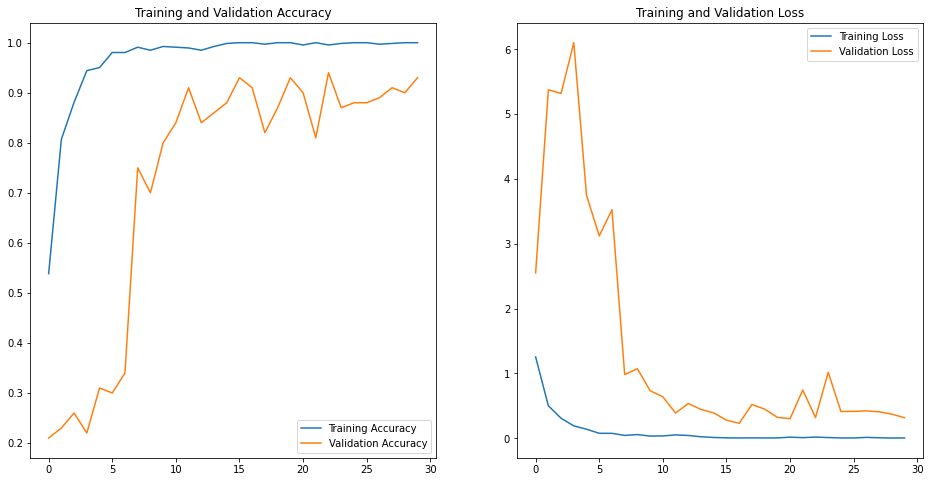

In [34]:
# Visualizing Model performance in a graph
acc = stat3.history['categorical_accuracy']
val_acc = stat3.history['val_categorical_accuracy']

loss = stat3.history['loss']
val_loss = stat3.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:

- With Batch normalisation, we can see that the loss for the validation data keeps decreasing stably after a few epochs which suggests that the model overfitting is reduced.
- The best performance of this model is at training accuracy of **99.5%** and validation accuracy of **94.0%**  
- Let's check the model performance with Dropout

### Model - IV

### - Convolution 3D model with Dropout

We are bulding the fourth Convolution 3D model with the following specifications:
- The model has 10 layers with 4 convolution 3D layers and 3 MaxPooling layers 
- The filtersize we are going to use is 3, 3, 3
- We are going to take odd indexed images from each video file for our training
- We are using an image size of 100X100 for training this model
- The learning rate is set to 0.0005
- We are adding Dropout in this model to check for performance improvements

In [35]:
# Parameters
dense = 64
classes = 5
filtersize = (3, 3, 3)
dropout = 0.25
a,b,c = 1, 29, 2
img_idx = img_indx(a, b, c)
x = len(img_idx)
y,z = 100, 100
lr1 = 0.0005

In [36]:
# Input
input_shape=(x, y, z, 3)

# Model
model4 = Sequential()

model4.add(Conv3D(16, filtersize, padding='same', input_shape=input_shape, activation='relu'))
model4.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2 , 2, 2)))
model4.add(Dropout(dropout))

model4.add(Conv3D(32, filtersize, padding='same', activation='relu'))
model4.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))
model4.add(Dropout(dropout))

model4.add(Conv3D(64, filtersize, padding='same', activation='relu'))
model4.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))
model4.add(Dropout(dropout))

model4.add(Conv3D(128, filtersize, padding='same', activation='relu'))
model4.add(Dropout(dropout))

model4.add(Flatten())
model4.add(Dense(dense, activation='relu'))
model4.add(Dropout(dropout))

model4.add(Dense(classes, activation='softmax'))

In [37]:
optimiser = tf.keras.optimizers.Adam(learning_rate=lr1, clipnorm=1.) #write your optimizer
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 14, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 7, 50, 50, 16)    0         
 3D)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 50, 50, 16)     0         
                                                                 
 conv3d_13 (Conv3D)          (None, 7, 50, 50, 32)     13856     
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 3, 25, 25, 32)    0         
 g3D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 3, 25, 25, 32)    

In [38]:
# Invoking generator function to call from models
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [39]:
model_name = 'Gesture_recognition' + '' + str(curr_dt_time).replace(' ','').replace(':','') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10, verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0, min_lr = 0)
callbacks_list = [checkpoint, LR]

In [40]:
stat4 = model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data//train ; batch size = 12
Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 1.6209 - categorical_accuracy: 0.1961Source path =  Project_data//val ; batch size = 12

Epoch 1: saving model to Gesture_recognition2022-03-30042043.466279\model-00001-1.62086-0.19608-1.59827-0.18000.h5
56/56 [==============================] - 60s 1s/step - loss: 1.6209 - categorical_accuracy: 0.1961 - val_loss: 1.5983 - val_categorical_accuracy: 0.1800 - lr: 5.0000e-04
Epoch 2/30
56/56 [==============================] - ETA: 0s - loss: 1.6042 - categorical_accuracy: 0.2127
Epoch 2: saving model to Gesture_recognition2022-03-30042043.466279\model-00002-1.60417-0.21267-1.60426-0.26000.h5
56/56 [==============================] - 59s 1s/step - loss: 1.6042 - categorical_accuracy: 0.2127 - val_loss: 1.6043 - val_categorical_accuracy: 0.2600 - lr: 5.0000e-04
Epoch 3/30
56/56 [==============================] - ETA: 0s - loss: 1.5713 - categorical_accuracy: 0.2474
Epoch 3:

Epoch 22/30
56/56 [==============================] - ETA: 0s - loss: 0.1111 - categorical_accuracy: 0.9638
Epoch 22: saving model to Gesture_recognition2022-03-30042043.466279\model-00022-0.11110-0.96380-0.61491-0.85000.h5
56/56 [==============================] - 59s 1s/step - loss: 0.1111 - categorical_accuracy: 0.9638 - val_loss: 0.6149 - val_categorical_accuracy: 0.8500 - lr: 5.0000e-04
Epoch 23/30
56/56 [==============================] - ETA: 0s - loss: 0.0726 - categorical_accuracy: 0.9744
Epoch 23: saving model to Gesture_recognition2022-03-30042043.466279\model-00023-0.07263-0.97436-0.69501-0.87000.h5
56/56 [==============================] - 59s 1s/step - loss: 0.0726 - categorical_accuracy: 0.9744 - val_loss: 0.6950 - val_categorical_accuracy: 0.8700 - lr: 5.0000e-04
Epoch 24/30
56/56 [==============================] - ETA: 0s - loss: 0.0613 - categorical_accuracy: 0.9804
Epoch 24: saving model to Gesture_recognition2022-03-30042043.466279\model-00024-0.06135-0.98039-0.47098-0.

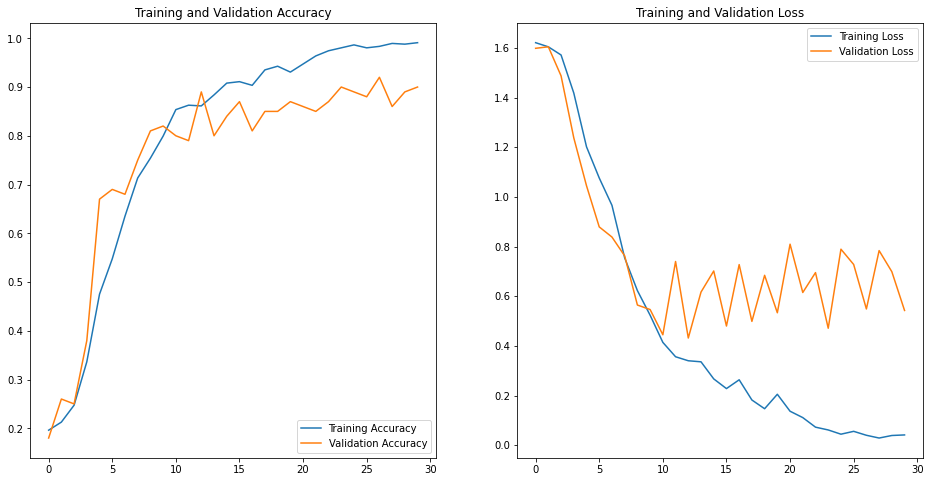

In [41]:
# Visualizing Model performance in a graph
acc = stat4.history['categorical_accuracy']
val_acc = stat4.history['val_categorical_accuracy']

loss = stat4.history['loss']
val_loss = stat4.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:

- With Dropout, we can see that the loss for the validation data keeps decreasing stably after a few epochs which suggests that the model overfitting is further reduced. The validation accuracy and training accuracy goes hand in hand with the epochs
- The best performance of this model is at training accuracy of **98.3%** and validation accuracy of **92.0%**  
- Let's check the model performance with Dropout and faster learning rate

### Model - V

### - Convolution 3D model with Dropout, faster learning rate

We are bulding the fifth Convolution 3D model with the following specifications:
- The model has 10 layers with 4 convolution 3D layers and 3 MaxPooling layers 
- The filtersize we are going to use is 3, 3, 3
- We are going to take odd indexed images from each video file for our training
- We are using an image size of 100X100 for training this model
- The learning rate is set to 0.001
- We are adding Dropout in this model to check for performance improvements

In [42]:
# Parameters
dense = 64
classes = 5
filtersize = (3, 3, 3)
dropout = 0.25
a,b,c = 1, 29, 2
img_idx = img_indx(a, b, c)
x = len(img_idx)
y,z = 100, 100
lr1 = 0.001

In [43]:
# Input
input_shape=(x, y, z, 3)

# Model
model5 = Sequential()

model5.add(Conv3D(16, filtersize, padding='same', input_shape=input_shape, activation='relu'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2 , 2, 2)))
model5.add(Dropout(dropout))

model5.add(Conv3D(32, filtersize, padding='same', activation='relu'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))
model5.add(Dropout(dropout))

model5.add(Conv3D(64, filtersize, padding='same', activation='relu'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))
model5.add(Dropout(dropout))

model5.add(Conv3D(128, filtersize, padding='same', activation='relu'))
model5.add(Dropout(dropout))

model5.add(Flatten())
model5.add(Dense(dense, activation='relu'))
model5.add(Dropout(dropout))

model5.add(Dense(classes, activation='softmax'))

In [44]:
optimiser = tf.keras.optimizers.Adam(learning_rate=lr1, clipnorm=1.) #write your optimizer
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 14, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 7, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 7, 50, 50, 16)     0         
                                                                 
 conv3d_17 (Conv3D)          (None, 7, 50, 50, 32)     13856     
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 3, 25, 25, 32)    0         
 g3D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 3, 25, 25, 32)    

In [45]:
# Invoking generator function to call from models
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [46]:
model_name = 'Gesture_recognition' + '' + str(curr_dt_time).replace(' ','').replace(':','') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10, verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0, min_lr = 0)
callbacks_list = [checkpoint, LR]

In [47]:
stat5 = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data//train ; batch size = 12
Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 1.6319 - categorical_accuracy: 0.2051Source path =  Project_data//val ; batch size = 12

Epoch 1: saving model to Gesture_recognition2022-03-30042043.466279\model-00001-1.63191-0.20513-1.60892-0.21000.h5
56/56 [==============================] - 60s 1s/step - loss: 1.6319 - categorical_accuracy: 0.2051 - val_loss: 1.6089 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
56/56 [==============================] - ETA: 0s - loss: 1.5525 - categorical_accuracy: 0.2655
Epoch 2: saving model to Gesture_recognition2022-03-30042043.466279\model-00002-1.55245-0.26546-1.41113-0.37000.h5
56/56 [==============================] - 59s 1s/step - loss: 1.5525 - categorical_accuracy: 0.2655 - val_loss: 1.4111 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 3/30
56/56 [==============================] - ETA: 0s - loss: 1.2675 - categorical_accuracy: 0.4600
Epoch 3: saving 

Epoch 22/30
56/56 [==============================] - ETA: 0s - loss: 0.1772 - categorical_accuracy: 0.9427
Epoch 22: saving model to Gesture_recognition2022-03-30042043.466279\model-00022-0.17725-0.94268-1.23968-0.81000.h5
56/56 [==============================] - 59s 1s/step - loss: 0.1772 - categorical_accuracy: 0.9427 - val_loss: 1.2397 - val_categorical_accuracy: 0.8100 - lr: 0.0010
Epoch 23/30
56/56 [==============================] - ETA: 0s - loss: 0.0760 - categorical_accuracy: 0.9683
Epoch 23: saving model to Gesture_recognition2022-03-30042043.466279\model-00023-0.07596-0.96833-0.84825-0.88000.h5
56/56 [==============================] - 59s 1s/step - loss: 0.0760 - categorical_accuracy: 0.9683 - val_loss: 0.8483 - val_categorical_accuracy: 0.8800 - lr: 0.0010
Epoch 24/30
56/56 [==============================] - ETA: 0s - loss: 0.0547 - categorical_accuracy: 0.9879
Epoch 24: saving model to Gesture_recognition2022-03-30042043.466279\model-00024-0.05472-0.98793-0.63845-0.91000.h5

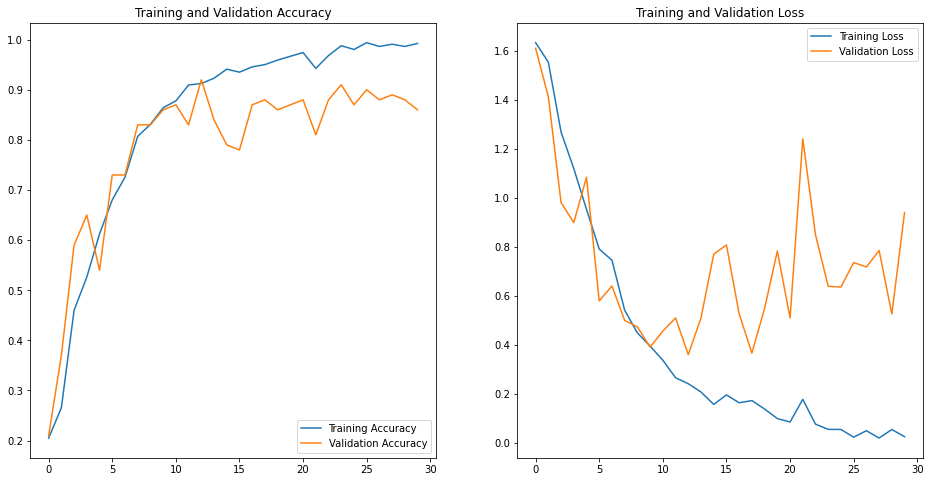

In [48]:
# Visualizing Model performance in a graph
acc = stat5.history['categorical_accuracy']
val_acc = stat5.history['val_categorical_accuracy']

loss = stat5.history['loss']
val_loss = stat5.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:

- With faster learning rate, we can see that the loss for the validation data keeps increasing after a few epochs which suggests that the model is overfitting slightly. The validation accuracy and training accuracy goes hand in hand with the epochs to some extent and then the validation accuracy starts to fall and validation loss keeps increasing. This suggests that our previous learning rate was performaing better than this rate.
- The best performance of this model is at training accuracy of **98.7%** and validation accuracy of **91.0%**  
- Let's create another model with Conv2D and LSTM

### Model - VI

### - Time Distributed Convolution 2D with LSTM model:

We are bulding the first Time distributed Convolution 2D model with the following specifications:
- The model has 11 layers with 4 Time distributed convolution 2D layers and 4 MaxPooling layers 
- We are going to take odd indexed images from each video file for our training
- We are using an image size of 100X100 for training this model
- The learning rate is set to 0.0005
- The LSTM layer is fed with 64 units

In [49]:
# Parameters
dense = 64
classes = 5
a,b,c = 1, 29, 2
img_idx = img_indx(a, b, c)
x = len(img_idx)
y,z = 100, 100
lr1 = 0.0005

In [50]:
# Input
input_shape=(x, y, z, 3)

# Model
model6 = Sequential()

model6.add(TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same'), input_shape=input_shape))
model6.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model6.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model6.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model6.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model6.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model6.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model6.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model6.add(TimeDistributed(GlobalAveragePooling2D()))

model6.add(LSTM(dense, return_sequences=False))
model6.add(Dense(classes, activation='softmax'))

In [51]:
optimiser = tf.keras.optimizers.Adam(learning_rate=lr1, clipnorm=1.) #write your optimizer
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 14, 100, 100, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 14, 50, 50, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 14, 50, 50, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 14, 25, 25, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 14, 25, 25, 64)  

In [52]:
# Invoking generator function to call from models
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [53]:
model_name = 'Gesture_recognition' + '' + str(curr_dt_time).replace(' ','').replace(':','') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10, verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0, min_lr = 0)
callbacks_list = [checkpoint, LR]

In [54]:
stat6 = model6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data//train ; batch size = 12
Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 1.6036 - categorical_accuracy: 0.2006Source path =  Project_data//val ; batch size = 12

Epoch 1: saving model to Gesture_recognition2022-03-30042043.466279\model-00001-1.60357-0.20060-1.56872-0.36000.h5
56/56 [==============================] - 62s 1s/step - loss: 1.6036 - categorical_accuracy: 0.2006 - val_loss: 1.5687 - val_categorical_accuracy: 0.3600 - lr: 5.0000e-04
Epoch 2/30
56/56 [==============================] - ETA: 0s - loss: 1.5369 - categorical_accuracy: 0.2790
Epoch 2: saving model to Gesture_recognition2022-03-30042043.466279\model-00002-1.53688-0.27903-1.65465-0.24000.h5
56/56 [==============================] - 60s 1s/step - loss: 1.5369 - categorical_accuracy: 0.2790 - val_loss: 1.6547 - val_categorical_accuracy: 0.2400 - lr: 5.0000e-04
Epoch 3/30
56/56 [==============================] - ETA: 0s - loss: 1.5438 - categorical_accuracy: 0.3002
Epoch 3:

Epoch 22/30
56/56 [==============================] - ETA: 0s - loss: 0.8142 - categorical_accuracy: 0.6486
Epoch 22: saving model to Gesture_recognition2022-03-30042043.466279\model-00022-0.81425-0.64857-0.84548-0.67000.h5
56/56 [==============================] - 60s 1s/step - loss: 0.8142 - categorical_accuracy: 0.6486 - val_loss: 0.8455 - val_categorical_accuracy: 0.6700 - lr: 5.0000e-04
Epoch 23/30
56/56 [==============================] - ETA: 0s - loss: 0.7550 - categorical_accuracy: 0.6637
Epoch 23: saving model to Gesture_recognition2022-03-30042043.466279\model-00023-0.75500-0.66365-0.65194-0.72000.h5
56/56 [==============================] - 59s 1s/step - loss: 0.7550 - categorical_accuracy: 0.6637 - val_loss: 0.6519 - val_categorical_accuracy: 0.7200 - lr: 5.0000e-04
Epoch 24/30
56/56 [==============================] - ETA: 0s - loss: 0.7408 - categorical_accuracy: 0.6772
Epoch 24: saving model to Gesture_recognition2022-03-30042043.466279\model-00024-0.74079-0.67722-0.96219-0.

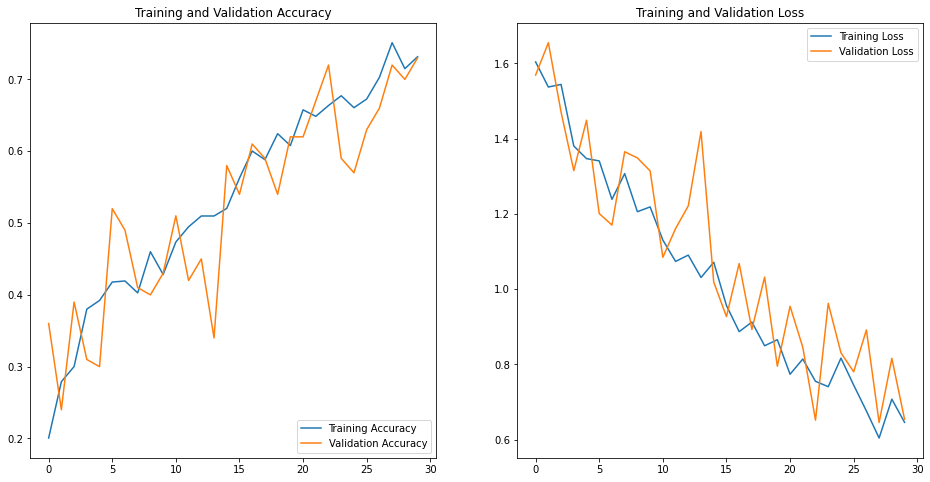

In [55]:
# Visualizing Model performance in a graph
acc = stat6.history['categorical_accuracy']
val_acc = stat6.history['val_categorical_accuracy']

loss = stat6.history['loss']
val_loss = stat6.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:

- We have used Time Distributed Conv2D layers followed by an LSTM layer for the model building. There is also MaxPooling layer to improve model stability.
- We can see the model is not overfitting since the validation accuracy goes hand in hand with the training accuracy.
- The loss for both training an validation are also decreasing stably with more number of epochs which suggests that the model is stable.
- We are able to achieve an accuracy of **73.1%** for training data and **73.0%** for validation data
- Next, let's check model performance adding dropout

### Model - VII

### - Time Distributed Convolution 2D with LSTM model with dropout:

We are bulding the second Time distributed Convolution 2D model with the following specifications:
- The model has 11 layers with 4 Time distributed convolution 2D layers and 4 MaxPooling layers 
- We are going to take odd indexed images from each video file for our training
- We are using an image size of 100X100 for training this model
- The learning rate is set to 0.0005
- The LSTM layer is fed with 32 units
- We are adding Dropout in this model to check for performance improvements

In [56]:
# Parameters
dense = 32
classes = 5
dropout = 0.25
a,b,c = 1, 29, 2
img_idx = img_indx(a, b, c)
x = len(img_idx)
y,z = 100, 100
lr1 = 0.0005

In [57]:
# Input
input_shape=(x, y, z, 3)

# Model
model7 = Sequential()

model7.add(TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same'), input_shape=input_shape))
model7.add(TimeDistributed(MaxPooling2D((2, 2))))
 
model7.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model7.add(TimeDistributed(MaxPooling2D((2, 2))))
 
model7.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model7.add(TimeDistributed(MaxPooling2D((2, 2))))
model7.add(Dropout(dropout))
 
model7.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model7.add(TimeDistributed(MaxPooling2D((2, 2))))
model7.add(Dropout(dropout))

model7.add(TimeDistributed(GlobalAveragePooling2D()))

model7.add(LSTM(32, return_sequences=False, recurrent_dropout=0.1))
model7.add(Dense(dense, activation='relu'))
model7.add(Dense(classes, activation='softmax'))

In [58]:
optimiser = tf.keras.optimizers.Adam(learning_rate=lr1, clipnorm=1.) #write your optimizer
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 14, 100, 100, 16)  448      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 14, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 14, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 14, 25, 25, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 14, 25, 25, 64)  

In [59]:
# Invoking generator function to call from models
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [60]:
model_name = 'Gesture_recognition' + '' + str(curr_dt_time).replace(' ','').replace(':','') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10, verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0, min_lr = 0)
callbacks_list = [checkpoint, LR]

In [61]:
stat7 = model7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data//train ; batch size = 12
Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 1.6107 - categorical_accuracy: 0.1961Source path =  Project_data//val ; batch size = 12

Epoch 1: saving model to Gesture_recognition2022-03-30042043.466279\model-00001-1.61066-0.19608-1.59604-0.17000.h5
56/56 [==============================] - 62s 1s/step - loss: 1.6107 - categorical_accuracy: 0.1961 - val_loss: 1.5960 - val_categorical_accuracy: 0.1700 - lr: 5.0000e-04
Epoch 2/30
56/56 [==============================] - ETA: 0s - loss: 1.5698 - categorical_accuracy: 0.2489
Epoch 2: saving model to Gesture_recognition2022-03-30042043.466279\model-00002-1.56983-0.24887-1.52461-0.28000.h5
56/56 [==============================] - 59s 1s/step - loss: 1.5698 - categorical_accuracy: 0.2489 - val_loss: 1.5246 - val_categorical_accuracy: 0.2800 - lr: 5.0000e-04
Epoch 3/30
56/56 [==============================] - ETA: 0s - loss: 1.5164 - categorical_accuracy: 0.3077
Epoch 3:

Epoch 22/30
56/56 [==============================] - ETA: 0s - loss: 0.7627 - categorical_accuracy: 0.6787
Epoch 22: saving model to Gesture_recognition2022-03-30042043.466279\model-00022-0.76271-0.67873-0.70117-0.70000.h5
56/56 [==============================] - 60s 1s/step - loss: 0.7627 - categorical_accuracy: 0.6787 - val_loss: 0.7012 - val_categorical_accuracy: 0.7000 - lr: 5.0000e-04
Epoch 23/30
56/56 [==============================] - ETA: 0s - loss: 0.7834 - categorical_accuracy: 0.6501
Epoch 23: saving model to Gesture_recognition2022-03-30042043.466279\model-00023-0.78344-0.65008-0.68922-0.76000.h5
56/56 [==============================] - 59s 1s/step - loss: 0.7834 - categorical_accuracy: 0.6501 - val_loss: 0.6892 - val_categorical_accuracy: 0.7600 - lr: 5.0000e-04
Epoch 24/30
56/56 [==============================] - ETA: 0s - loss: 0.7831 - categorical_accuracy: 0.6742
Epoch 24: saving model to Gesture_recognition2022-03-30042043.466279\model-00024-0.78310-0.67421-1.19135-0.

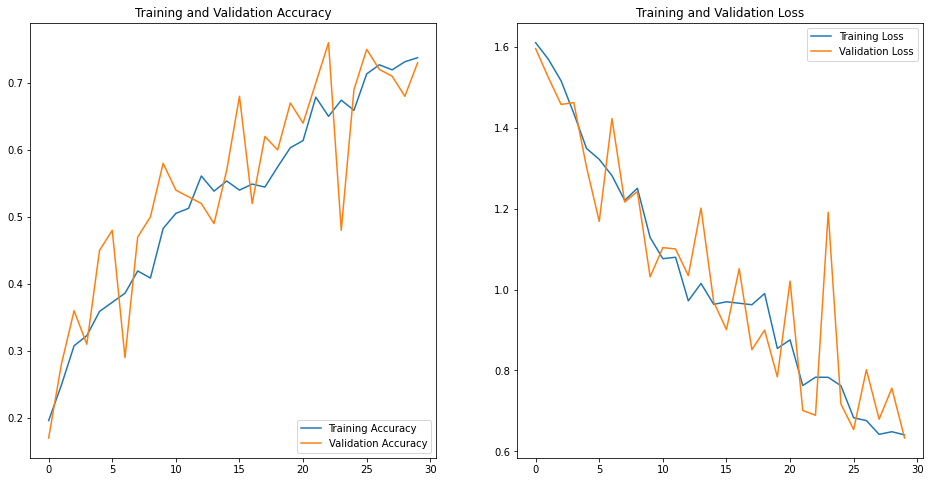

In [62]:
# Visualizing Model performance in a graph
acc = stat7.history['categorical_accuracy']
val_acc = stat7.history['val_categorical_accuracy']

loss = stat7.history['loss']
val_loss = stat7.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:

- We have used Time Distributed Conv2D layers followed by an LSTM layer for the model building. There is also MaxPooling layer to improve model stability.
- We are able to achieve an accuracy of **73.7%** for training data and **73.0%** for validation data. Adding dropout only added a very slight improvement in performance
- Next, let's check model performance with GRU

### Model - VIII

### - Time Distributed Convolution 2D with GRU model:

We are bulding the second Time distributed Convolution 2D model with GRU with the following specifications:
- The model has 11 layers with 4 Time distributed convolution 2D layers and 4 MaxPooling layers 
- We are going to take odd indexed images from each video file for our training
- We are using an image size of 100X100 for training this model
- The learning rate is set to 0.0005
- The GRU layer is fed with 64 units

In [63]:
# Parameters
dense = 64
classes = 5
dropout = 0.25
a,b,c = 1, 29, 2
img_idx = img_indx(a, b, c)
x = len(img_idx)
y,z = 100, 100
lr1 = 0.0005

In [64]:
# Input
input_shape=(x, y, z, 3)

# Model
model8 = Sequential()

model8.add(TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same'), input_shape=input_shape))
model8.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model8.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model8.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model8.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model8.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model8.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model8.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model8.add(TimeDistributed(GlobalAveragePooling2D()))

model8.add(GRU(dense, return_sequences=False))
model8.add(Dense(classes, activation='softmax'))

In [65]:
optimiser = tf.keras.optimizers.Adam(learning_rate=lr1, clipnorm=1.) #write your optimizer
model8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model8.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 14, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 14, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 14, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 14, 25, 25, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 14, 25, 25, 64)  

In [66]:
# Invoking generator function to call from models
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [67]:
model_name = 'Gesture_recognition' + '' + str(curr_dt_time).replace(' ','').replace(':','') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10, verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0, min_lr = 0)
callbacks_list = [checkpoint, LR]

In [68]:
stat8 = model8.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data//train ; batch size = 12
Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 1.6065 - categorical_accuracy: 0.1946Source path =  Project_data//val ; batch size = 12

Epoch 1: saving model to Gesture_recognition2022-03-30042043.466279\model-00001-1.60654-0.19457-1.57448-0.23000.h5
56/56 [==============================] - 60s 1s/step - loss: 1.6065 - categorical_accuracy: 0.1946 - val_loss: 1.5745 - val_categorical_accuracy: 0.2300 - lr: 5.0000e-04
Epoch 2/30
56/56 [==============================] - ETA: 0s - loss: 1.5372 - categorical_accuracy: 0.2609
Epoch 2: saving model to Gesture_recognition2022-03-30042043.466279\model-00002-1.53717-0.26094-1.42107-0.41000.h5
56/56 [==============================] - 59s 1s/step - loss: 1.5372 - categorical_accuracy: 0.2609 - val_loss: 1.4211 - val_categorical_accuracy: 0.4100 - lr: 5.0000e-04
Epoch 3/30
56/56 [==============================] - ETA: 0s - loss: 1.4212 - categorical_accuracy: 0.3273
Epoch 3:

Epoch 22/30
56/56 [==============================] - ETA: 0s - loss: 0.7640 - categorical_accuracy: 0.6606
Epoch 22: saving model to Gesture_recognition2022-03-30042043.466279\model-00022-0.76398-0.66063-0.82053-0.67000.h5
56/56 [==============================] - 58s 1s/step - loss: 0.7640 - categorical_accuracy: 0.6606 - val_loss: 0.8205 - val_categorical_accuracy: 0.6700 - lr: 5.0000e-04
Epoch 23/30
56/56 [==============================] - ETA: 0s - loss: 0.7113 - categorical_accuracy: 0.6983
Epoch 23: saving model to Gesture_recognition2022-03-30042043.466279\model-00023-0.71128-0.69834-0.63152-0.69000.h5
56/56 [==============================] - 66s 1s/step - loss: 0.7113 - categorical_accuracy: 0.6983 - val_loss: 0.6315 - val_categorical_accuracy: 0.6900 - lr: 5.0000e-04
Epoch 24/30
56/56 [==============================] - ETA: 0s - loss: 0.6322 - categorical_accuracy: 0.7572
Epoch 24: saving model to Gesture_recognition2022-03-30042043.466279\model-00024-0.63216-0.75716-0.79871-0.

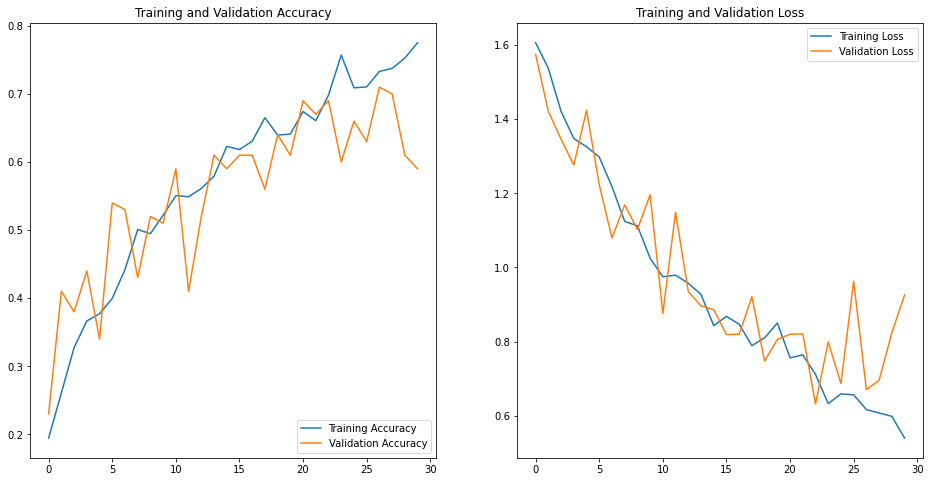

In [69]:
# Visualizing Model performance in a graph
acc = stat8.history['categorical_accuracy']
val_acc = stat8.history['val_categorical_accuracy']

loss = stat8.history['loss']
val_loss = stat8.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:

- We have used Time Distributed Conv2D layers followed by an GRU layer for the model building. There is also MaxPooling layer to improve model stability.
- We are able to achieve an accuracy of **73.0%** for training data and **71.0%** for validation data. 
- Using GRU decreased the model training time with respect to LSTM due to less number of traning parameters. But that also slightly decreased overall performance for the model. The accuracy for LSTM is better than in GRU 
- Next, let's check model performance with GRU and dropout

### - Model IX:

### - Time Distributed Convolution 2D with GRU model with dropout:

We are bulding the second Time distributed Convolution 2D model with GRU with the following specifications:
- The model has 11 layers with 4 Time distributed convolution 2D layers and 4 MaxPooling layers 
- We are going to take odd indexed images from each video file for our training
- We are using an image size of 100X100 for training this model
- The learning rate is set to 0.0005
- The GRU layer is fed with 64 units
- We are adding Dropout in this model to check for performance improvements

In [70]:
# Parameters
dense = 64
classes = 5
dropout = 0.25
a,b,c = 1, 29, 2
img_idx = img_indx(a, b, c)
x = len(img_idx)
y,z = 100, 100
lr1 = 0.0005

In [71]:
# Input
input_shape=(x, y, z, 3)

# Model
model9 = Sequential()

model9.add(TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same'), input_shape=input_shape))
model9.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model9.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model9.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model9.add(Dropout(dropout))
 
model9.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model9.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model9.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model9.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model9.add(Dropout(dropout))

model9.add(TimeDistributed(GlobalAveragePooling2D()))

model9.add(GRU(dense, return_sequences=False))
model9.add(Dense(classes, activation='softmax'))

In [72]:
optimiser = tf.keras.optimizers.Adam(learning_rate=lr1, clipnorm=1.) #write your optimizer
model9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model9.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_27 (TimeDi  (None, 14, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 14, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 14, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 14, 25, 25, 32)   0         
 stributed)                                                      
                                                                 
 dropout_12 (Dropout)        (None, 14, 25, 25, 32)   

In [73]:
# Invoking generator function to call from models
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [74]:
model_name = 'Gesture_recognition' + '' + str(curr_dt_time).replace(' ','').replace(':','') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10, verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0, min_lr = 0)
callbacks_list = [checkpoint, LR]

In [75]:
stat9 = model9.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data//train ; batch size = 12
Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 1.6169 - categorical_accuracy: 0.1840Source path =  Project_data//val ; batch size = 12

Epoch 1: saving model to Gesture_recognition2022-03-30042043.466279\model-00001-1.61692-0.18401-1.60454-0.20000.h5
56/56 [==============================] - 61s 1s/step - loss: 1.6169 - categorical_accuracy: 0.1840 - val_loss: 1.6045 - val_categorical_accuracy: 0.2000 - lr: 5.0000e-04
Epoch 2/30
56/56 [==============================] - ETA: 0s - loss: 1.5880 - categorical_accuracy: 0.2534
Epoch 2: saving model to Gesture_recognition2022-03-30042043.466279\model-00002-1.58804-0.25339-1.51656-0.27000.h5
56/56 [==============================] - 59s 1s/step - loss: 1.5880 - categorical_accuracy: 0.2534 - val_loss: 1.5166 - val_categorical_accuracy: 0.2700 - lr: 5.0000e-04
Epoch 3/30
56/56 [==============================] - ETA: 0s - loss: 1.4912 - categorical_accuracy: 0.3107
Epoch 3:

Epoch 22/30
56/56 [==============================] - ETA: 0s - loss: 0.8377 - categorical_accuracy: 0.6229
Epoch 22: saving model to Gesture_recognition2022-03-30042043.466279\model-00022-0.83765-0.62293-0.73610-0.72000.h5
56/56 [==============================] - 58s 1s/step - loss: 0.8377 - categorical_accuracy: 0.6229 - val_loss: 0.7361 - val_categorical_accuracy: 0.7200 - lr: 5.0000e-04
Epoch 23/30
56/56 [==============================] - ETA: 0s - loss: 0.7388 - categorical_accuracy: 0.6848
Epoch 23: saving model to Gesture_recognition2022-03-30042043.466279\model-00023-0.73884-0.68477-0.66651-0.68000.h5
56/56 [==============================] - 59s 1s/step - loss: 0.7388 - categorical_accuracy: 0.6848 - val_loss: 0.6665 - val_categorical_accuracy: 0.6800 - lr: 5.0000e-04
Epoch 24/30
56/56 [==============================] - ETA: 0s - loss: 0.7562 - categorical_accuracy: 0.6697
Epoch 24: saving model to Gesture_recognition2022-03-30042043.466279\model-00024-0.75625-0.66968-0.78664-0.

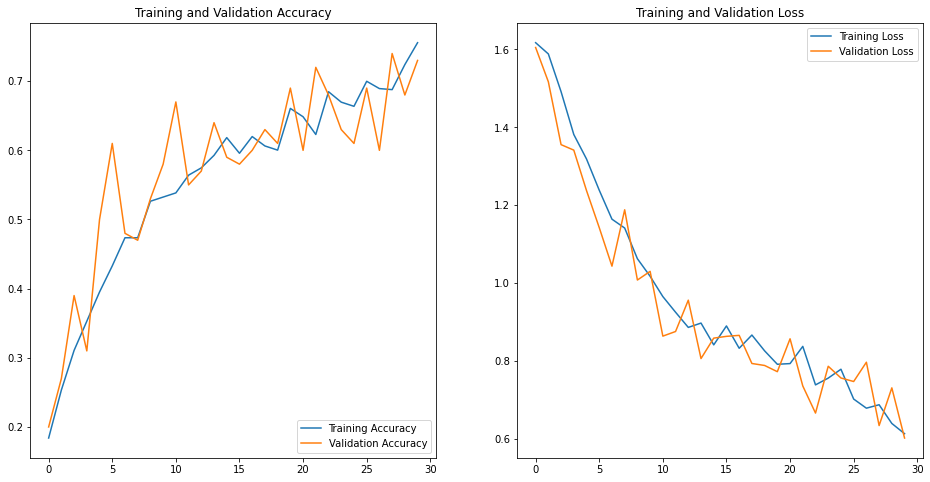

In [76]:
# Visualizing Model performance in a graph
acc = stat9.history['categorical_accuracy']
val_acc = stat9.history['val_categorical_accuracy']

loss = stat9.history['loss']
val_loss = stat9.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:

- We have used Time Distributed Conv2D layers followed by an GRU layer for the model building. There is also MaxPooling layer to improve model stability.
- We are able to achieve an accuracy of **75.5%** for training data and **73.0%** for validation data. 
- Using GRU with dropout performed better than without dropout. The model perforance increased. 
- Next, let's check model performance with GRU and dropout

### - Transfer learing using MobileNet V2:

- Transfer learning is simply the process of using a pre-trained model that has been trained on a dataset for training and predicting on a new given dataset.
- MobileNet V2 model was developed at Google, pre-trained on the ImageNet dataset with 1.4M images and 1000 classes of web images. We will use this as our base model to train with our dataset and classify the Gestures.

In [77]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [78]:
conv2d = MobileNetV2(weights='imagenet', include_top=False)
conv2d.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 80
# Freeze all the layers before the `fine_tune_at` layer
for layer in conv2d.layers[:fine_tune_at]:
    layer.trainable =  False

- We are going to fine tune the model parameters after 80 layers.

### Model X:

### - Transfer learing using MobileNet with LSTM model:

We are bulding the Time distributed Convolution 2D model with transfer learning using MobileNetV2 with LSTM using the following specifications:
- The model has 5 layers with MobileNetV2 Time distributed convolution 2D, followed by LSTM RNN
- We are going to take odd indexed images from each video file for our training
- We are using an image size of 100X100 for training this model
- The learning rate is set to 0.0005
- The LSTM layer is fed with 64 units
- We are adding Dropout in this model to check for performance improvements

In [79]:
# Parameters
dense = 64
classes = 5
dropout = 0.35
a,b,c = 1, 29, 2
img_idx = img_indx(a, b, c)
x = len(img_idx)
y,z = 100, 100
lr1 = 0.0005

In [80]:
# Input
input_shape=(x, y, z, 3)
# Model
model10 = Sequential()

model10.add(TimeDistributed(conv2d,input_shape=input_shape))
model10.add(BatchNormalization())
model10.add(Dropout(dropout))

model10.add(TimeDistributed(GlobalAveragePooling2D()))
model10.add(LSTM(dense, return_sequences=False))
model10.add(Dropout(dropout))

model10.add(Dense(dense,activation ='relu'))

model10.add(Dense(5, activation='softmax'))

In [81]:
optimiser = tf.keras.optimizers.Adam(learning_rate=lr1, clipnorm=1.) #write your optimizer
model10.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model10.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_36 (TimeDi  (None, 14, 3, 3, 1280)   2257984   
 stributed)                                                      
                                                                 
 batch_normalization_5 (Batc  (None, 14, 3, 3, 1280)   5120      
 hNormalization)                                                 
                                                                 
 dropout_14 (Dropout)        (None, 14, 3, 3, 1280)    0         
                                                                 
 time_distributed_37 (TimeDi  (None, 14, 1280)         0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 32)                168064    
                                                      

In [82]:
# Invoking generator function to call from models
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [83]:
model_name = 'Gesture_recognition' + '' + str(curr_dt_time).replace(' ','').replace(':','') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10, verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0, min_lr = 0)
callbacks_list = [checkpoint, LR]

In [84]:
stat10 = model10.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data//train ; batch size = 12
Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 1.3629 - categorical_accuracy: 0.4706Source path =  Project_data//val ; batch size = 12

Epoch 1: saving model to Gesture_recognition2022-03-30042043.466279\model-00001-1.36295-0.47059-1.26984-0.49000.h5
56/56 [==============================] - 70s 1s/step - loss: 1.3629 - categorical_accuracy: 0.4706 - val_loss: 1.2698 - val_categorical_accuracy: 0.4900 - lr: 5.0000e-04
Epoch 2/30
56/56 [==============================] - ETA: 0s - loss: 0.6219 - categorical_accuracy: 0.8507
Epoch 2: saving model to Gesture_recognition2022-03-30042043.466279\model-00002-0.62186-0.85068-0.57782-0.80000.h5
56/56 [==============================] - 61s 1s/step - loss: 0.6219 - categorical_accuracy: 0.8507 - val_loss: 0.5778 - val_categorical_accuracy: 0.8000 - lr: 5.0000e-04
Epoch 3/30
56/56 [==============================] - ETA: 0s - loss: 0.2771 - categorical_accuracy: 0.9412
Epoch 3:

Epoch 22/30
56/56 [==============================] - ETA: 0s - loss: 0.0144 - categorical_accuracy: 0.9970
Epoch 22: saving model to Gesture_recognition2022-03-30042043.466279\model-00022-0.01441-0.99698-0.10786-0.97000.h5
56/56 [==============================] - 60s 1s/step - loss: 0.0144 - categorical_accuracy: 0.9970 - val_loss: 0.1079 - val_categorical_accuracy: 0.9700 - lr: 5.0000e-05
Epoch 23/30
56/56 [==============================] - ETA: 0s - loss: 0.0174 - categorical_accuracy: 0.9970
Epoch 23: saving model to Gesture_recognition2022-03-30042043.466279\model-00023-0.01738-0.99698-0.12093-0.96000.h5
56/56 [==============================] - 60s 1s/step - loss: 0.0174 - categorical_accuracy: 0.9970 - val_loss: 0.1209 - val_categorical_accuracy: 0.9600 - lr: 5.0000e-05
Epoch 24/30
56/56 [==============================] - ETA: 0s - loss: 0.0206 - categorical_accuracy: 0.9955
Epoch 24: saving model to Gesture_recognition2022-03-30042043.466279\model-00024-0.02060-0.99548-0.08042-0.

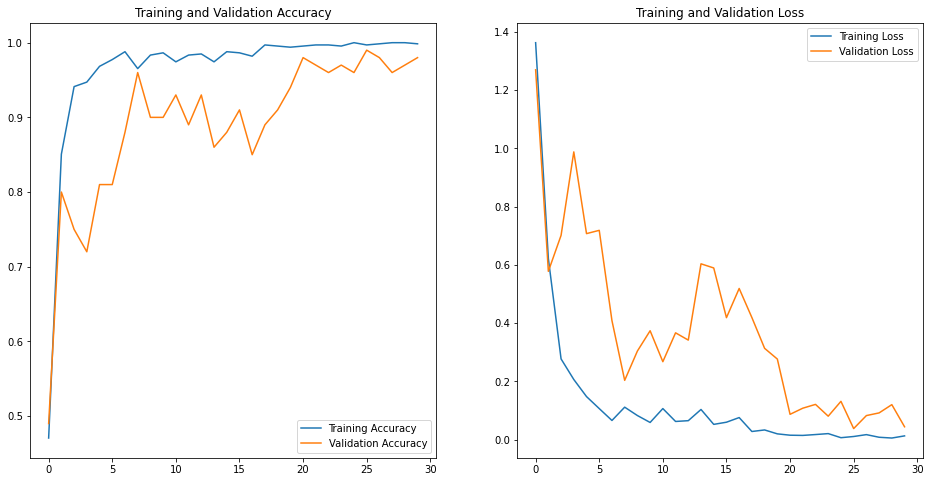

In [85]:
# Visualizing Model performance in a graph
acc = stat10.history['categorical_accuracy']
val_acc = stat10.history['val_categorical_accuracy']

loss = stat10.history['loss']
val_loss = stat10.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:

- We have created a Time Distributed Conv2D model with Transfer learning using MobileNetV2 with LSTM RNN
- We can see good accuracy and low loss on both the training and validation data.
- We were able to acheive the best model accuracy of **99.8%** on training data and **98.0%** on validation data
- Using dropout, we were able to acheive good validation accuracy as well.
- Next, lets build a model with Time Distributed Conv2D model with Transfer learning using MobileNetV2 with GRU RNN

### Model XI

### - Transfer learing using MobileNet with GRU model

We are bulding the Time distributed Convolution 2D model with transfer learning using MobileNetV2 with GRU using the following specifications:
- The model has 5 layers with MobileNetV2 Time distributed convolution 2D, followed by GRU RNN
- We are going to take odd indexed images from each video file for our training
- We are using an image size of 100X100 for training this model
- The learning rate is set to 0.0005
- The GRU layer is fed with 32 units
- We are adding Dropout in this model to check for performance improvements

In [86]:
# Parameters
dense = 32
classes = 5
dropout = 0.35
a,b,c = 1, 29, 2
img_idx = img_indx(a, b, c)
x = len(img_idx)
y,z = 100, 100
lr1 = 0.0005

In [87]:
# Input
input_shape=(x, y, z, 3)

# Model
model11 = Sequential()

model11.add(TimeDistributed(conv2d,input_shape=input_shape))
model11.add(BatchNormalization())
model11.add(Dropout(dropout))

model11.add(TimeDistributed(GlobalAveragePooling2D()))
model11.add(GRU(dense, return_sequences=False))
model11.add(Dropout(dropout))

model11.add(Dense(dense,activation ='relu'))

model11.add(Dense(5, activation='softmax'))

In [88]:
optimiser = tf.keras.optimizers.Adam(learning_rate=lr1, clipnorm=1.) #write your optimizer
model11.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model11.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_38 (TimeDi  (None, 14, 3, 3, 1280)   2257984   
 stributed)                                                      
                                                                 
 batch_normalization_6 (Batc  (None, 14, 3, 3, 1280)   5120      
 hNormalization)                                                 
                                                                 
 dropout_16 (Dropout)        (None, 14, 3, 3, 1280)    0         
                                                                 
 time_distributed_39 (TimeDi  (None, 14, 1280)         0         
 stributed)                                                      
                                                                 
 gru_2 (GRU)                 (None, 32)                126144    
                                                     

In [92]:
# Invoking generator function to call from models
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [89]:
model_name = 'Gesture_recognition' + '' + str(curr_dt_time).replace(' ','').replace(':','') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10, verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0, min_lr = 0)
callbacks_list = [checkpoint, LR]

In [90]:
stat11 = model11.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 0.2628 - categorical_accuracy: 0.9578
Epoch 1: saving model to Gesture_recognition2022-03-30042043.466279\model-00001-0.26279-0.95777-0.28695-0.92000.h5
56/56 [==============================] - 68s 1s/step - loss: 0.2628 - categorical_accuracy: 0.9578 - val_loss: 0.2870 - val_categorical_accuracy: 0.9200 - lr: 5.0000e-04
Epoch 2/30
56/56 [==============================] - ETA: 0s - loss: 0.0748 - categorical_accuracy: 0.9910
Epoch 2: saving model to Gesture_recognition2022-03-30042043.466279\model-00002-0.07479-0.99095-0.15977-0.96000.h5
56/56 [==============================] - 61s 1s/step - loss: 0.0748 - categorical_accuracy: 0.9910 - val_loss: 0.1598 - val_categorical_accuracy: 0.9600 - lr: 5.0000e-04
Epoch 3/30
56/56 [==============================] - ETA: 0s - loss: 0.0576 - categorical_accuracy: 0.9925
Epoch 3: saving model to Gesture_recognition2022-03-30042043.466279\model-00003-0.05756-0.99246-0.55017-0.87000.

Epoch 22/30
56/56 [==============================] - ETA: 0s - loss: 0.0099 - categorical_accuracy: 0.9970
Epoch 22: saving model to Gesture_recognition2022-03-30042043.466279\model-00022-0.00995-0.99698-0.34916-0.94000.h5
56/56 [==============================] - 61s 1s/step - loss: 0.0099 - categorical_accuracy: 0.9970 - val_loss: 0.3492 - val_categorical_accuracy: 0.9400 - lr: 5.0000e-05
Epoch 23/30
56/56 [==============================] - ETA: 0s - loss: 0.0178 - categorical_accuracy: 0.9970
Epoch 23: saving model to Gesture_recognition2022-03-30042043.466279\model-00023-0.01777-0.99698-0.20801-0.97000.h5
56/56 [==============================] - 60s 1s/step - loss: 0.0178 - categorical_accuracy: 0.9970 - val_loss: 0.2080 - val_categorical_accuracy: 0.9700 - lr: 5.0000e-06
Epoch 24/30
56/56 [==============================] - ETA: 0s - loss: 0.0129 - categorical_accuracy: 0.9955
Epoch 24: saving model to Gesture_recognition2022-03-30042043.466279\model-00024-0.01288-0.99548-0.32250-0.

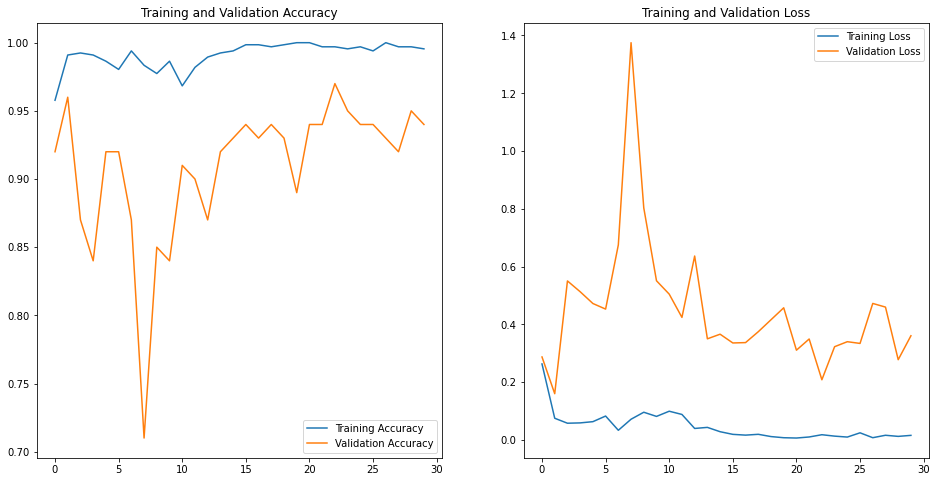

In [91]:
# Visualizing Model performance in a graph
acc = stat11.history['categorical_accuracy']
val_acc = stat11.history['val_categorical_accuracy']

loss = stat11.history['loss']
val_loss = stat11.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:

- We have created a Time Distributed Conv2D model with Transfer learning using MobileNetV2 with GRU RNN
- We can see the accuracy and loss for training and validation data are not as good as with the LSTM model.
- We were able to acheive the best model accuracy of **99.0%** on training data and **97.0%** on validation data

### Model XII

### - Transfer learing using MobileNet with LSTM model (more training data):

We are bulding the Time distributed Convolution 2D model with transfer learning using MobileNetV2 with LSTM using the following specifications:
- The model has 5 layers with MobileNetV2 Time distributed convolution 2D, followed by LSTM RNN
- We are going to take all images from each video file for our training
- We are using an image size of 100X100 for training this model
- The learning rate is set to 0.0005
- The LSTM layer is fed with 64 units
- We are adding Dropout in this model to check for performance improvements

In [137]:
# Parameters
dense = 32
classes = 5
dropout = 0.35
a,b,c = 1, 29, 1
img_idx = img_indx(a, b, c)
x = len(img_idx)
y,z = 100, 100
lr1 = 0.0005
batch_size = 8 # The batch size had to be reduced to accomodate the images in one instance of GPU memory

In [138]:
# Input
input_shape=(x, y, z, 3)
# Model
model12 = Sequential()

model12.add(TimeDistributed(conv2d,input_shape=input_shape))
model12.add(BatchNormalization())
model12.add(Dropout(dropout))

model12.add(TimeDistributed(GlobalAveragePooling2D()))
model12.add(LSTM(dense, return_sequences=False))
model12.add(Dropout(dropout))

model12.add(Dense(dense,activation ='relu'))

model12.add(Dense(5, activation='softmax'))

In [139]:
optimiser = tf.keras.optimizers.Adam(learning_rate=lr1, clipnorm=1.) #write your optimizer
model12.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model12.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_44 (TimeDi  (None, 28, 3, 3, 1280)   2257984   
 stributed)                                                      
                                                                 
 batch_normalization_9 (Batc  (None, 28, 3, 3, 1280)   5120      
 hNormalization)                                                 
                                                                 
 dropout_27 (Dropout)        (None, 28, 3, 3, 1280)    0         
                                                                 
 time_distributed_45 (TimeDi  (None, 28, 1280)         0         
 stributed)                                                      
                                                                 
 lstm_5 (LSTM)               (None, 32)                168064    
                                                     

In [140]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [141]:
# Invoking generator function to call from models
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [142]:
model_name = 'Gesture_recognition' + '' + str(curr_dt_time).replace(' ','').replace(':','') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10, verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0, min_lr = 0)
callbacks_list = [checkpoint, LR]

In [143]:
stat12 = model12.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data//train ; batch size = 8
Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 0.3856 - categorical_accuracy: 0.9427Source path =  Project_data//val ; batch size = 8

Epoch 1: saving model to Gesture_recognition2022-03-30042043.466279\model-00001-0.38557-0.94268-0.23932-0.96000.h5
83/83 [==============================] - 136s 2s/step - loss: 0.3856 - categorical_accuracy: 0.9427 - val_loss: 0.2393 - val_categorical_accuracy: 0.9600 - lr: 5.0000e-04
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 0.0833 - categorical_accuracy: 0.9940
Epoch 2: saving model to Gesture_recognition2022-03-30042043.466279\model-00002-0.08325-0.99397-0.35528-0.92000.h5
83/83 [==============================] - 125s 2s/step - loss: 0.0833 - categorical_accuracy: 0.9940 - val_loss: 0.3553 - val_categorical_accuracy: 0.9200 - lr: 5.0000e-04
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 0.0462 - categorical_accuracy: 0.9910
Epoch 3:

Epoch 22/30
83/83 [==============================] - ETA: 0s - loss: 0.0508 - categorical_accuracy: 0.9910
Epoch 22: saving model to Gesture_recognition2022-03-30042043.466279\model-00022-0.05084-0.99095-0.51746-0.93000.h5
83/83 [==============================] - 123s 1s/step - loss: 0.0508 - categorical_accuracy: 0.9910 - val_loss: 0.5175 - val_categorical_accuracy: 0.9300 - lr: 5.0000e-05
Epoch 23/30
83/83 [==============================] - ETA: 0s - loss: 0.0287 - categorical_accuracy: 0.9925
Epoch 23: saving model to Gesture_recognition2022-03-30042043.466279\model-00023-0.02868-0.99246-0.25339-0.96000.h5
83/83 [==============================] - 124s 2s/step - loss: 0.0287 - categorical_accuracy: 0.9925 - val_loss: 0.2534 - val_categorical_accuracy: 0.9600 - lr: 5.0000e-05
Epoch 24/30
83/83 [==============================] - ETA: 0s - loss: 0.0109 - categorical_accuracy: 0.9985
Epoch 24: saving model to Gesture_recognition2022-03-30042043.466279\model-00024-0.01093-0.99849-0.30890-

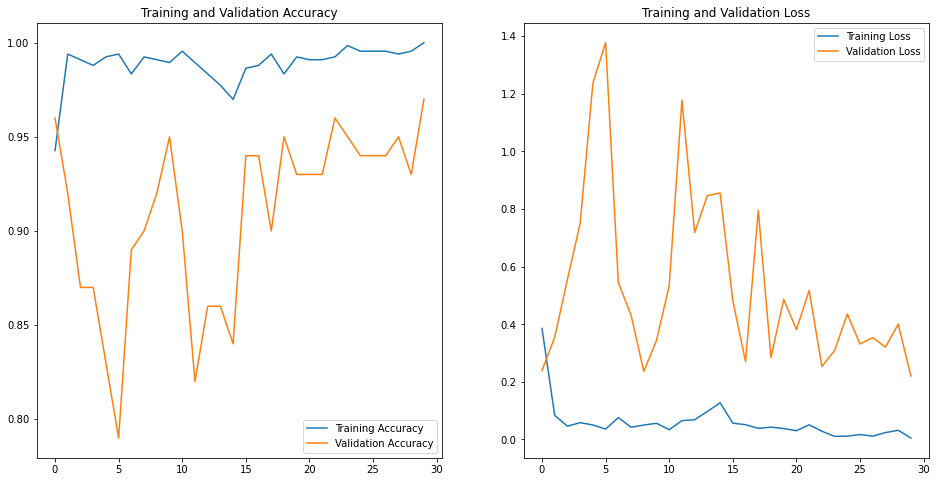

In [144]:
# Visualizing Model performance in a graph
acc = stat12.history['categorical_accuracy']
val_acc = stat12.history['val_categorical_accuracy']

loss = stat12.history['loss']
val_loss = stat12.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:

- We can see that the improvement in using more training data is not huge. The training time has increased a lot due to adding more training data. We can consider the previous setup for the model as it was fast and provided a really good result.
- We were able to acheive the best model accuracy of **99.25%** on training data and **96.0%** on validation data

### Model XIII

### - Convolution 3D model with Dropout - Increased layers:

We are bulding the fourth Convolution 3D model with the following specifications:
- The model has 13 layers with 7 convolution 3D layers and 3 MaxPooling layers 
- The filtersize we are going to use is 3, 3, 3
- We are going to take odd indexed images from each video file for our training
- We are using an image size of 100X100 for training this model
- The learning rate is set to 0.0005
- We are adding Dropout in this model to check for performance improvements

In [145]:
# Parameters
dense = 32
classes = 5
filtersize = (3, 3, 3)
dropout = 0.25
a,b,c = 1, 29, 2
img_idx = img_indx(a, b, c)
x = len(img_idx)
y,z = 100, 100
lr1 = 0.0005
batch_size = 12

In [146]:
# Input
input_shape=(x, y, z, 3)

# Model
model13 = Sequential()

model13.add(Conv3D(16, filtersize, padding='same', input_shape=input_shape, activation='relu'))
model13.add(Conv3D(16, filtersize, padding='same', input_shape=input_shape, activation='relu'))
model13.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2 , 2, 2)))
model13.add(Dropout(dropout))

model13.add(Conv3D(32, filtersize, padding='same', activation='relu'))
model13.add(Conv3D(32, filtersize, padding='same', activation='relu'))
model13.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))
model13.add(Dropout(dropout))

model13.add(Conv3D(64, filtersize, padding='same', activation='relu'))
model13.add(Conv3D(64, filtersize, padding='same', activation='relu'))
model13.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))
model13.add(Dropout(dropout))

model13.add(Conv3D(128, filtersize, padding='same', activation='relu'))
model13.add(Dropout(dropout))

model13.add(Flatten())
model13.add(Dense(dense, activation='relu'))
model13.add(Dropout(dropout))

model13.add(Dense(classes, activation='softmax'))

In [147]:
optimiser = tf.keras.optimizers.Adam(learning_rate=lr1, clipnorm=1.) #write your optimizer
model13.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model13.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_27 (Conv3D)          (None, 14, 100, 100, 16)  1312      
                                                                 
 conv3d_28 (Conv3D)          (None, 14, 100, 100, 16)  6928      
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 7, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 dropout_29 (Dropout)        (None, 7, 50, 50, 16)     0         
                                                                 
 conv3d_29 (Conv3D)          (None, 7, 50, 50, 32)     13856     
                                                                 
 conv3d_30 (Conv3D)          (None, 7, 50, 50, 32)     27680     
                                                     

In [148]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [149]:
# Invoking generator function to call from models
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [150]:
model_name = 'Gesture_recognition' + '' + str(curr_dt_time).replace(' ','').replace(':','') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10, verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0, min_lr = 0)
callbacks_list = [checkpoint, LR]

In [151]:
stat13 = model13.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data//train ; batch size = 12
Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 1.6092 - categorical_accuracy: 0.2247Source path =  Project_data//val ; batch size = 12

Epoch 1: saving model to Gesture_recognition2022-03-30042043.466279\model-00001-1.60917-0.22474-1.58582-0.24000.h5
56/56 [==============================] - 65s 1s/step - loss: 1.6092 - categorical_accuracy: 0.2247 - val_loss: 1.5858 - val_categorical_accuracy: 0.2400 - lr: 5.0000e-04
Epoch 2/30
56/56 [==============================] - ETA: 0s - loss: 1.5405 - categorical_accuracy: 0.2911
Epoch 2: saving model to Gesture_recognition2022-03-30042043.466279\model-00002-1.54052-0.29110-1.40029-0.39000.h5
56/56 [==============================] - 62s 1s/step - loss: 1.5405 - categorical_accuracy: 0.2911 - val_loss: 1.4003 - val_categorical_accuracy: 0.3900 - lr: 5.0000e-04
Epoch 3/30
56/56 [==============================] - ETA: 0s - loss: 1.2671 - categorical_accuracy: 0.4540
Epoch 3:

Epoch 22/30
56/56 [==============================] - ETA: 0s - loss: 0.0585 - categorical_accuracy: 0.9834
Epoch 22: saving model to Gesture_recognition2022-03-30042043.466279\model-00022-0.05848-0.98341-0.39717-0.92000.h5
56/56 [==============================] - 63s 1s/step - loss: 0.0585 - categorical_accuracy: 0.9834 - val_loss: 0.3972 - val_categorical_accuracy: 0.9200 - lr: 5.0000e-04
Epoch 23/30
56/56 [==============================] - ETA: 0s - loss: 0.0633 - categorical_accuracy: 0.9774
Epoch 23: saving model to Gesture_recognition2022-03-30042043.466279\model-00023-0.06331-0.97738-0.80938-0.87000.h5
56/56 [==============================] - 62s 1s/step - loss: 0.0633 - categorical_accuracy: 0.9774 - val_loss: 0.8094 - val_categorical_accuracy: 0.8700 - lr: 5.0000e-04
Epoch 24/30
56/56 [==============================] - ETA: 0s - loss: 0.0792 - categorical_accuracy: 0.9698
Epoch 24: saving model to Gesture_recognition2022-03-30042043.466279\model-00024-0.07923-0.96983-0.79489-0.

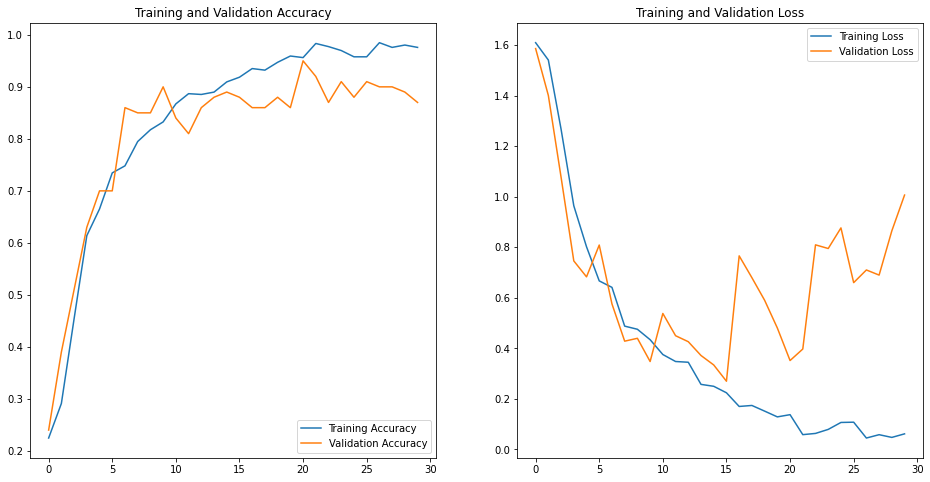

In [152]:
# Visualizing Model performance in a graph
acc = stat13.history['categorical_accuracy']
val_acc = stat13.history['val_categorical_accuracy']

loss = stat13.history['loss']
val_loss = stat13.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:

- Adding more layers to the Conv3D model has good performance in terms of accuracy on both training and validation dataset. But it was also noticed that the validation loss is decreasing at first with increasing epochs and then increasing in a U shaped manner.
- We were able to acheive the best model accuracy of **95.63%** on training data and **95.0%** on validation data

### Conclusion:

The most accurate model that performed the best among all the other models is the one with MobileNetV2 - Transfer learning with Time Distribution together with LSTM (model10). It has the best accuracy on both training and validation data together with very low loss. We can consider the trained model Gesture_recognition2022-03-30042043.466279\model-00030-0.01278-0.99849-0.04407-0.98000.h5 for predicting the Gestures.